## Datos de entrada

El set de datos seleccionado consta de las construcciones en Costa Rica realizadas por el sector privado extraido por medio de una encuesta anual que se realiza por el Instituo Nacional de Estadísticas y Censo (INEC) desde el año 2002 hasta el año 2018 con excepción del año 2008 que no se realizó esta encuesta.

Nombre | Etiqueta | Pregunta | Tipo de dato
--- | --- | --- | ---
anoper | Año del permiso | Fecha (año): | Numérico
num_obras | Número de obras | Indique Nº de obras:  | Numérico
arecon | Area de construcción | Área de construcción (metros cuadrados m2)  | Numérico
valobr | Valor de la obra | Valor de la obra (Colones):  | Numérico
claper | Clase del permiso | Permiso para:  | Categórico
claobr | Clase de la obra | Clase de obra: | Categórico
numpis | Número de pisos | Número de pisos | Numérico
numviv | Número de viviendas | Nº de viviendas (incluye apartamentos). | Numérico
numapo | Número de aposentos | Nº total de aposentos | Numérico
numdor | Número de dormitorios | Nº de aposentos usados como dormitorios | Numérico
matpis | Material de piso | Materiales predominantes. Pisos: | Categórico
matpar | Material de pared | Materiales predominantes. Paredes: | Categórico
mattec | Material de techo | Materiales predominantes. Techos: | Categórico
usoobr | Uso de la obra | La construcción de la obra será para: | Categórico
financ | Financiamiento | Financiamiento (Marque únicamente el de mayor aporte): | Categórico
cod_provincia | Codigo Provincia | Codigo Provincia | Categórico
provincia | Nombre Provincia | Nombre Provincia | Texto (se ingora)
id_canton | Codigo Canton | Codigo Canton | Categórico (se ignora)
canton | Nombre Canton | Nombre Canton | Texto (se ignora)
id_region | Codigo Region | Codigo Region | Categórico
cat | Categoría | **Valor de predicción** | Categórico binario. 


Todos estas columnas menos la columna *id_region* son tomados de la encuesta realizada por el INEC. La columna *id_region* es calculada utilizando la siguente [referencia](https://es.wikipedia.org/wiki/Regiones_socioecon%C3%B3micas_de_Costa_Rica).


In [90]:
## IMPORTANTE - Variables locales. Modificar

#spark_home_location = '/usr/local/Cellar/apache-spark/2.4.4/libexec'
spark_home_location = '../sparkenv/lib/python3.7/site-packages/pyspark'
database_name = 'postgres'
database_user_name = 'mario'
database_password = ''
database_table = 'tarea3'

## Preprocesamiento de datos

In [91]:
import findspark
import pandas as pd
import matplotlib.pyplot as plt

findspark.init(spark_home_location)

from pyspark.sql.types import (StringType, LongType, BinaryType, StructField, StructType, DoubleType)

from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Basic JDBC pipeline") \
    .config("spark.driver.extraClassPath", "postgresql-42.1.4.jar") \
    .config("spark.executor.extraClassPath", "postgresql-42.1.4.jar") \
    .getOrCreate()

construction_df = spark \
    .read \
    .format("csv") \
    .option("path", "construction_data.csv") \
    .option("header", True) \
    .schema(StructType([
                StructField("anoper", StringType()),
                StructField("num_obras", LongType()),
                StructField("arecon", LongType()),
                StructField("valobr", LongType()),
                StructField("claper", LongType()),
                StructField("claobr", LongType()),
                StructField("numpis", LongType()),
                StructField("numviv", LongType()),
                StructField("numapo", LongType()),
                StructField("numdor", LongType()),
                StructField("matpis", LongType()),
                StructField("matpar", LongType()),
                StructField("mattec", LongType()),
                StructField("usoobr", LongType()),
                StructField("financ", LongType()),
                StructField("cod_provincia", LongType()),
                StructField("provincia", StringType()),
                StructField("id_canton", LongType()),
                StructField("canton", StringType()),
                StructField("id_region", LongType()),
                StructField("cat", LongType())])) \
    .load()

columns_kept = ['num_obras', 'arecon', 'numpis', 'numdor',
                'id_region', 'financ', 'matpis', 'matpar', 'cat']
construction_df = construction_df.select(columns_kept)

construction_df.show()

+---------+------+------+------+---------+------+------+------+---+
|num_obras|arecon|numpis|numdor|id_region|financ|matpis|matpar|cat|
+---------+------+------+------+---------+------+------+------+---+
|        1|  4585|    10|    64|        1|     1|    33|     1|  1|
|        1|   323|     2|     4|        1|    99|    22|     1|  1|
|        2|   162|     1|     2|        1|    99|    22|     1|  1|
|        1|   763|     2|     5|        1|    99|    34|     1|  1|
|        1|   212|     2|     3|        1|    99|    22|    27|  1|
|        1|    42|     1|     2|        1|    99|     7|     8|  0|
|        1|   103|     1|     3|        1|    99|    22|     1|  1|
|        1|    46|     1|     2|        1|    99|     7|     8|  0|
|        1|    42|     1|     2|        1|    99|     7|     8|  0|
|        1|    42|     1|     2|        1|     6|     7|     8|  0|
|        1|    42|     1|     2|        1|     6|     7|     8|  0|
|        1|    42|     1|     2|        1|     6

## Guardar en base de datos

In [92]:
construction_df \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://localhost/" + database_name) \
    .option("user", database_user_name) \
    .option("password", database_password) \
    .option("dbtable", database_table) \
    .save()

## Leer de la base de datos

In [93]:
# read the data
construction_df = spark \
    .read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://localhost/" + database_name) \
    .option("user", database_user_name) \
    .option("password", database_password) \
    .option("dbtable", database_table) \
    .load()

# set variables
features = ['num_obras', 'arecon', 'numpis', 'numdor',
               'id_region', 'financ', 'matpis', 'matpar']
label = 'cat'

# use a small sample to make it run faster
construction_df = construction_df.sample(False, 0.01, seed=0)

## Descripción de los datos

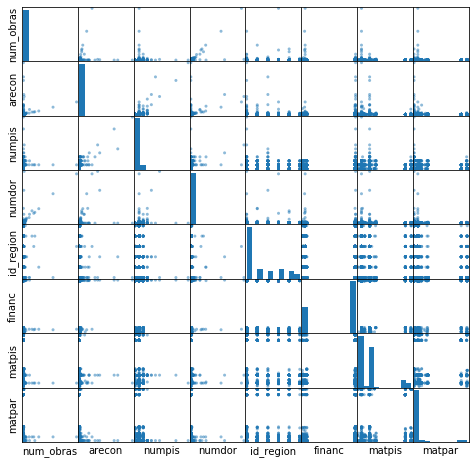

In [94]:
# get a sample of data, convert it to pandas dataframe and create the scatter matrix with all features
construction_df_pandas = construction_df.select(features).toPandas()

n = len(construction_df_pandas.columns)
axs = pd.plotting.scatter_matrix(construction_df_pandas, figsize=(n, n));
for i in range(n):
    axs[i, 0].set_yticks(())
    axs[n-1, i].set_xticks(())


## Estandarización y correlación

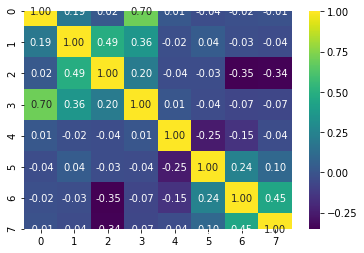

In [103]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import seaborn as sns
import matplotlib.pyplot as plt

# create the vector assembler and standarize the dataset
assembler = VectorAssembler(
    inputCols=features,
    outputCol='features')

vector_df = assembler.transform(construction_df)

standard_scaler = StandardScaler(inputCol='features', outputCol='features_scaled')
scale_model = standard_scaler.fit(vector_df)
construction_scaled_df = scale_model.transform(vector_df)

# run the correlation
pearson_matrix = Correlation.corr(construction_scaled_df, 'features_scaled').collect()[0][0]
sns.heatmap(pearson_matrix.toArray(), annot=True, fmt=".2f", cmap='viridis')

## Entrenamiento y evaluación para regresión logística y SVN

In [104]:
from pyspark.sql.functions import row_number, col, lit, explode
from pyspark.sql.window import Window
from pyspark.ml.classification import DecisionTreeClassifier, LogisticRegression, LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import numpy as np

# Split test and train
train_df, test_df = construction_scaled_df.randomSplit([0.9, 0.1])

print('train_df size: ', train_df.count())

# This trick is to add a unique incremental rownumber
split_df = train_df.withColumn('col',lit('dummy'))
split_df = split_df.withColumn("row_num", row_number() \
                   .over(Window().partitionBy('col').orderBy('col'))) \
                   .drop('col')

# Split the dataset into k groups
k = 4
group_size = int(split_df.count() / k)

group_dfs = []
for group_index in range(k):
    min_row_num = group_index * group_size
    max_row_num = (group_index + 1) * group_size
    filter_expression = 'row_num >= {0} and row_num < {1}'.format(min_row_num, max_row_num)
    group_dfs.append(split_df.filter(filter_expression))    
    

# Perform k-fold cross validation
    
def train_and_evaluate_logistic_regression(train, test):
    print('Training Logistic Regression...')
    lr = LogisticRegression(featuresCol = 'features_scaled', labelCol = 'cat', maxIter=10)
    lrModel = lr.fit(train)
    predictions = lrModel.transform(test)
    evaluator = BinaryClassificationEvaluator(labelCol="cat")
    print('Logistic Regression AUC: ', evaluator.evaluate(predictions))  
    
def train_and_evaluate_support_vector_machine(train, test):
    print('Training Support Vector Machine...')
    lsvc = LinearSVC(featuresCol = 'features_scaled', labelCol = 'cat', maxIter=10, regParam=0.1)
    lsvcModel = lsvc.fit(train)
    predictions = lsvcModel.transform(test)
    evaluator = BinaryClassificationEvaluator(labelCol="cat")
    print('Support Vector Machine AUC: ', evaluator.evaluate(predictions))
    
    
for i in range(k):
    df_cross_val_train = spark.createDataFrame(spark.sparkContext.emptyRDD(), split_df.schema)
    df_cross_val_test = spark.createDataFrame(spark.sparkContext.emptyRDD(), split_df.schema)
    for j in range(k):
        if i == j:
            df_cross_val_test = df_cross_val_test.union(group_dfs[j])
        else:
            df_cross_val_train = df_cross_val_train.union(group_dfs[j])    
    
    print('Training size: ', df_cross_val_train.count())
    train_and_evaluate_logistic_regression(df_cross_val_train, df_cross_val_test)
    train_and_evaluate_support_vector_machine(df_cross_val_train, df_cross_val_test)
    



train_df size:  4138
Training size:  3102
Training Logistic Regression...
Logistic Regression AUC:  0.4777366044807905
Training Support Vector Machine...
Support Vector Machine AUC:  0.5291890280262379
Training size:  3101
Training Logistic Regression...
Logistic Regression AUC:  0.6446006131065997
Training Support Vector Machine...
Support Vector Machine AUC:  0.621927236971485
Training size:  3101
Training Logistic Regression...
Logistic Regression AUC:  0.6900731003132867
Training Support Vector Machine...
Support Vector Machine AUC:  0.6178983148023018
Training size:  3101
Training Logistic Regression...
Logistic Regression AUC:  0.803310522060522
Training Support Vector Machine...
Support Vector Machine AUC:  0.6444689882189881


Nota: No pude lograr unir todos los modelos obtenidos con el k-fold cross validation.

## Generar la predicción y guardarla en la base de datos

In [115]:
lr = LogisticRegression(featuresCol = 'features_scaled', labelCol = 'cat', maxIter=10)
lrModel = lr.fit(train_df)
lr_predictions = lrModel.transform(test_df)

lsvc = LinearSVC(featuresCol = 'features_scaled', labelCol = 'cat', maxIter=10, regParam=0.1)
lsvcModel = lsvc.fit(train_df)
lsvc_predictions = lsvcModel.transform(test_df)

cols = ['num_obras', 'arecon', 'numpis', 'numdor',
        'id_region', 'financ', 'matpis', 'matpar', 'cat', 'prediction']

lr_predictions \
    .select(cols) \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://localhost/" + database_name) \
    .option("user", database_user_name) \
    .option("password", database_password) \
    .option("dbtable", 'modelo1') \
    .save()

lsvc_predictions \
    .select(cols) \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://localhost/" + database_name) \
    .option("user", database_user_name) \
    .option("password", database_password) \
    .option("dbtable", 'modelo2') \
    .save()

## Análisis de los resultados

Tras correr los expermientos con regresión logísitca y con SVN se puede observar lo siguiente:
* No se están corriendo los experimentos sobre todos los 500 mil datos. Sólo se corren sobre el 1% al rededor de 50 mil datos porque es súmamente lento correrlo en una máquina local.
* Los resultados rondan entre el 50% y el 70% del AUC, lo cual es muy negativo. Con datos que en el pasado se había demostrado podían llegar hasta el 90% con regresión logística.
* Los resultados de la regresión logísitica son un poco mejores que el de SVN.